# Hospital Patient Prediction Models

In this notebook, our goal is to create predictive models for estimating the number of patients diagnosed with various conditions, including COVID-19, influenza (grippe), respiratory syncytial virus (RSV), and other respiratory infections. Additionally, we aim to predict hospital admissions, deaths, and patients in critical care units over a two-week period.

Let’s look at creating the Machine learning pipeline using MLFLow. Points covered are model tunning, model building, model logging on MLFlow, registering the best model on MLFlow model registry and dynamically using the best models for the prediction.

## Methodology

1. **Model Tuner** :

In the industrial projects, it’s very rare that only one model would solve the problem. There can be multiple models built to find various predictions. For example there can be multiple (hundreds) of timeseries models built to forecast various features. Tuning these models manually every time when new actuals are available can be cumbersome. So a Model tuner is created to find the best hyperparameters of the models every time new actuals are available.

2. **DL table** :

Once the best hyperparameters are found using tuner, they are stored in a table.

3. **Predictions** :

Using the best hyperparameters, models are built every time new actuals are available. With this we get the most updated models built on latest actuals. The version of the model present in that environment on the model registry is used to make the predictions using Model prediction.

SARIMAX is the extension of the ARIMA models with seasonality. Hence, SARIMAX takes into account the parameters involved in regular ARIMA mode (p,d,q) and also adds seasonality parameters (P,D,Q,s). These arguments to SARIMAX model are called order (p,d,q) and seasonal order (P,D,Q,s) respectively and hence 7 parameters to tun : SARIMAX (p,d,q) x (P,D,Q,s)

### 0.1. Import libraries

In [58]:
import itertools

# Define ranges for parameters
p_max = q_max = 2
p_range = q_range = range(0, p_max + 1)
d_value = 1
D_value = 1
week = 5

# Initialize the parameters dictionary
params = {}

# Generate combinations and populate the dictionary
index = 0
for (p, q) in itertools.product(p_range, q_range):
    if week == 0:
        P_range = Q_range = [0]
        D_value = 0
    else:
        P_range = Q_range = range(0, 2)

    for (P, Q) in itertools.product(P_range, Q_range):
        params[index] = [(p, d_value, q), (P, D_value, Q, week)]
        index += 1

# Print the dictionary in the desired format
for key, value in params.items():
    print(f"{key}:", value)

0: [(0, 1, 0), (0, 1, 0, 5)]
1: [(0, 1, 0), (0, 1, 1, 5)]
2: [(0, 1, 0), (1, 1, 0, 5)]
3: [(0, 1, 0), (1, 1, 1, 5)]
4: [(0, 1, 1), (0, 1, 0, 5)]
5: [(0, 1, 1), (0, 1, 1, 5)]
6: [(0, 1, 1), (1, 1, 0, 5)]
7: [(0, 1, 1), (1, 1, 1, 5)]
8: [(0, 1, 2), (0, 1, 0, 5)]
9: [(0, 1, 2), (0, 1, 1, 5)]
10: [(0, 1, 2), (1, 1, 0, 5)]
11: [(0, 1, 2), (1, 1, 1, 5)]
12: [(1, 1, 0), (0, 1, 0, 5)]
13: [(1, 1, 0), (0, 1, 1, 5)]
14: [(1, 1, 0), (1, 1, 0, 5)]
15: [(1, 1, 0), (1, 1, 1, 5)]
16: [(1, 1, 1), (0, 1, 0, 5)]
17: [(1, 1, 1), (0, 1, 1, 5)]
18: [(1, 1, 1), (1, 1, 0, 5)]
19: [(1, 1, 1), (1, 1, 1, 5)]
20: [(1, 1, 2), (0, 1, 0, 5)]
21: [(1, 1, 2), (0, 1, 1, 5)]
22: [(1, 1, 2), (1, 1, 0, 5)]
23: [(1, 1, 2), (1, 1, 1, 5)]
24: [(2, 1, 0), (0, 1, 0, 5)]
25: [(2, 1, 0), (0, 1, 1, 5)]
26: [(2, 1, 0), (1, 1, 0, 5)]
27: [(2, 1, 0), (1, 1, 1, 5)]
28: [(2, 1, 1), (0, 1, 0, 5)]
29: [(2, 1, 1), (0, 1, 1, 5)]
30: [(2, 1, 1), (1, 1, 0, 5)]
31: [(2, 1, 1), (1, 1, 1, 5)]
32: [(2, 1, 2), (0, 1, 0, 5)]
33: [(2, 1, 2), (0, 

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pmdarima as pm

import itertools

import os
import pandas as pd
import re

from kedro.pipeline import *
from kedro.io import *
from kedro.runner import *

import pickle
import os
from kedro.framework.hooks import _create_hook_manager
from kedro.framework.context import KedroContext, KedroContextError

import mlflow


### 0.2. Read final df

In [2]:
# Specify the file path
file_path = 'C:/Users/jrubio/hcl-model-project/data/05_model_input/final_df.csv'


# Read the CSV file into a DataFrame
final_df = pd.read_csv(file_path)
week = 0

In [3]:
import os
import pandas as pd
import re

from kedro.pipeline import *
from kedro.io import *
from kedro.runner import *

import pickle
import os
from kedro.framework.hooks import _create_hook_manager
from kedro.framework.context import KedroContext, KedroContextError



In [4]:
week = 0
final_df.columns = ['NUM_SEMAINE', 'CATEG_DIAG','NB_PATIENTS','IS_DEATH','NB_IS_DEATH','IS_CRITIC','NB_IS_CRITIC']
filtered_df = final_df[(final_df['IS_DEATH'] == 'Oui') & (final_df['IS_CRITIC'] == 'Oui')].drop(['IS_DEATH', 'IS_CRITIC'], axis=1)
filtered_df


NUM_SEMAINE   CATEG_DIAG  NB_PATIENTS  NB_IS_DEATH  NB_IS_CRITIC
3              1     COVID-19           80            5            20
7              1       GRIPPE           94            6            17
11             1  IR_AUTVIRUS           30            1             9
15             1  IR_GENERALE          387           34           103
19             1          RSV           12            1             9
..           ...          ...          ...          ...           ...
455           26  IR_GENERALE           73            1            17
459           27     COVID-19            3            0             1
463           27  IR_AUTVIRUS            2            0             1
467           27  IR_GENERALE           48            3            11
471           28  IR_GENERALE           22            0             5

[118 rows x 5 columns]

### 1. Model Tuner

We will use custom gridsearch to find the best parameters. To do this lets define the list of parameters in the format [(p,d,q), (P,D,Q,s)]


In [5]:
import itertools

week = 0  # Mettez ici la valeur de la semaine

p = q = range(0, 3)
d = range(0, 2)

# Si week est égal à 0, alors pas de saisonnalité (0, 0, 0, 0), sinon p, d, q comme saisonniers
if week == 0:
    pdqs = [(0, 0, 0, 0)]
    params = {
    0:[(1,1,1), (0, 0, 0, 0)],
    1:[(1,1,0), (0, 0, 0, 0)],
    2:[(1,1,0), (0, 0, 0, 0)],
    3:[(1,1,0), (0, 0, 0, 0)],
    4:[(1,1,1), (0, 0, 0, 0)],
    5:[(1,1,1), (0, 0, 0, 0)],
    6:[(1,1,2), (0, 0, 0, 0)],
    7:[(1,1,1), (0, 0, 0, 0)],
    8:[(1,1,1), (0, 0, 0, 0)],
    9:[(1,1,0), (0, 0, 0, 0)],
    10:[(2,1,1), (0, 0, 0, 0)],
    11:[(2,1,1), (0, 0, 0, 0)],
    12:[(2,1,1), (0, 0, 0, 0)],
    13:[(1,1,2), (0, 0, 0, 0)],
    14:[(1,1,2), (0, 0, 0, 0)],
    15:[(0,1,1), (0, 0, 0, 0)]
    }
else:
    params = {
    0:[(1,1,1), (1,1,1,week)],
    1:[(1,1,0), (1,1,1,week)],
    2:[(1,1,0), (1,1,0,week)],
    3:[(1,1,0), (0,1,0,week)],
    4:[(1,1,1), (1,1,0,week)],
    5:[(1,1,1), (2,1,0,week)],
    6:[(1,1,2), (1,1,2,week)],
    7:[(1,1,1), (1,1,2,week)],
    8:[(1,1,1), (2,1,2,week)],
    9:[(1,1,0), (1,1,2,week)],
    10:[(2,1,1), (2,1,1,week)],
    11:[(2,1,1), (1,1,1,week)],
    12:[(2,1,1), (1,1,0,week)],
    13:[(1,1,2), (2,1,2,week)],
    14:[(1,1,2), (1,1,0,week)],
    15:[(0,1,1), (1,1,1,week)]
    }
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], week) for x in pdq]


We need models for every pathologies. So lets define lists to get them and also step=2 specifies the steps of the forecast we need.

In [8]:

df = filtered_df
columns=['NB_PATIENTS', 'NB_IS_DEATH','NB_IS_CRITIC']
cat_diag=[i for i in df['CATEG_DIAG'].unique()]
steps=2

We are using AIC as the metric to get the best parameters. Model with lowest AIC is picked to be best and the parameters corresponding to that model are stored as the best_param. In most timeseries models we use all the available actuals to train the model. This is because the most actual data will tell us the behavior of the future forecasts. 
Due to this we cannot split timeseries into test and train and hence cannot use our regression metrics like RMSE or MAE. So we relay on either Maximum Likelihood, AIC or BIC. In this study, we are using AIC as the metric.



In [12]:
def sarimax_gridsearch(data, d_values, q_values, P_values, D_values, Q_values, s):
    best_model = None
    best_aic = float("inf")

    param_grid = list(product(d_values, q_values, P_values, D_values, Q_values))
    for params in param_grid:
        p, d, q, P, D, Q = params
        try:
            model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s))
            results = model.fit(disp=False)
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_params = params
        except:
            continue

    return best_model, best_params

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1, 2]
s = 52  # Weekly seasonality

# Perform grid search

forecast_steps = 2
ans = []
par={}
t = 'COVID-19'
c = 'NB_PATIENTS'
data=df[df['CATEG_DIAG']==t]

best_model, best_params = sarimax_gridsearch(df, d_values, q_values, P_values, D_values, Q_values, s)

print("Best SARIMAX Model:")
print("Order:", best_params[:3])
print("Seasonal Order:", best_params[3:])

In [10]:
forecast_steps = 2
ans = []
par={}
t = 'COVID-19'
c = 'NB_PATIENTS'
data=df[df['CATEG_DIAG']==t]

df_ans=sarimax_gridsearch(data[c],t,c,params)

[08/28/23 17:01:52] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=801853;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=903868;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=31817;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=904733;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=733477;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=958331;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=798928;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=69408;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=9555;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=344012;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=264504;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=514818;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=262285;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=220837;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=568852;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=905030;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=160673;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=552482;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=616222;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=452694;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=190.75329846914053 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=384114;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=123699;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=209788;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=232267;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=612613;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=549372;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=566386;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=746804;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=41232;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=898689;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=190.75329846914053 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=85772;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=658749;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=124832;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=622190;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=595643;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=523056;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=460245;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=712534;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=948349;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=255167;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=190.75329846914053 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=282046;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=471952;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=887149;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=841053;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=485110;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=108699;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=420012;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=958273;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=927400;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=514228;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=338110;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=137299;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=286015;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=263363;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=536289;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=697589;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=983948;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=243218;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=386352;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=570261;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=713786;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=207821;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=487455;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=20760;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=691480;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=846365;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=757930;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=888369;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=339259;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=548120;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=168.34502199319073 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=355668;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=896495;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=75591;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=203565;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=184816;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=928102;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=568051;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=674863;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=601375;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=77613;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=563313;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=617434;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=625070;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=90143;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=232671;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=887125;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=490261;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=384055;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=138503;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=848826;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=460490;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=104115;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=518937;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=457796;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=504008;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=284107;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=588129;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=717362;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=898401;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=431503;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=190.75329846914053 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=259976;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=540647;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=152025;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=977687;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/28/23 17:01:53] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=795745;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=756234;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=671921;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=996454;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=988786;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=9142;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.89620885088067 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=167933;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=993411;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=394928;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=463179;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=175869;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=410385;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=584239;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=67973;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=233525;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=503766;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.89620885088067 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=266548;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=542748;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=803773;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=137201;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=363046;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=76479;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=858992;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=783655;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=955720;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=694667;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.89620885088067 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=178790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=305127;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=348066;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=124641;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=431562;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=339342;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=76906;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=898000;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=906426;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=213;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=168.34502199319073 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=567836;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=72920;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=170956;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=937284;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=590966;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=508650;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=889614;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=348550;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=118408;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=589545;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=168.34502199319073 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=496643;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=48950;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=724015;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=186677;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=661319;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=545207;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=331894;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=519179;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=833232;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=469886;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=178.08442064603787 


NUM_SEMAINE   CATEG_DIAG  NB_PATIENTS  NB_IS_DEATH  NB_IS_CRITIC
3              1     COVID-19           80            5            20
7              1       GRIPPE           94            6            17
11             1  IR_AUTVIRUS           30            1             9
15             1  IR_GENERALE          387           34           103
19             1          RSV           12            1             9
..           ...          ...          ...          ...           ...
455           26  IR_GENERALE           73            1            17
459           27     COVID-19            3            0             1
463           27  IR_AUTVIRUS            2            0             1
467           27  IR_GENERALE           48            3            11
471           28  IR_GENERALE           22            0             5

[118 rows x 5 columns]

Now lets define a function to auto tune the SARIMAX model and store the parameters with the lowest AIC score.



In [6]:
#function returns dataframe with best parameters
def sarimax_gridsearch(ts,cat_diag,col,params):
    '''
    Input: 
        ts : time series data
        cat_diag : patho of the current model
        col : parameter on which the model is being built
        maxiter : number of iterations, increase if the model isn't converging
        frequency : default='M' for month. Change to suit the time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Print and save out top parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''
# Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for i in range(0,len(params)):
        
        mod = SARIMAX(ts,
                      order=params[i][0],
                      seasonal_order=params[i][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False
                     )
 
        output = mod.fit()

        ans.append([cat_diag,col,params[i][0][0],params[i][0][1],params[i][0][2], params[i][1][0],params[i][1][1],params[i][1][2],params[i][1][3],params[i][0],params[i][1], abs(output.aic)])
        forecast = output.get_forecast(steps=forecast_steps, alpha=0.05)  # alpha=0.05 for 95% confidence interval
        print('SARIMAX {} x {} Weekly seasonality : parameters {},{} AIC={} '.format(cat_diag,col,params[i][0], params[i][1], abs(output.aic)))
# Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['cat_diag','param','p','d','q', 'Ps','Ds','Qs','Ss','pdq','pdqs', 'aic'])
# Sort and return top  combination
    ans_df = ans_df.sort_values(by=['cat_diag','param','aic'],ascending=True)[0:1]
    
    return ans_df

The above function accepts the actual data ,parameter grid (params) and corresponding cat_diag and product_category (col) as input. The output of this function is a dataframe with best parameters ((p,d,q),(P,D,Q,s)) along with the AIC value for the parameter combination for each  cat_diag and parameter combination.

Below code shows how to call the above function

The above code snippet mainly does these steps

Step 1 — Once data is filtered for a particular patho, it is passed into the gridsearch function to get the best parameters for each pathos

Step 2 — Stores the best parameters for each pathos into a master best_param dataframe

Step 3 — SAXIMAX model is built using the best parameter for each pathos combination to make prediction for the next 2 weeks

Step 4 — Stores the forecast of the next 2 weeks for each pathos in a master master prediction dataframe

In [41]:
best_param=pd.DataFrame() # --- Dataframe to store the best parameters for each cat_diag
prediction=pd.DataFrame() # -- Dataframe to store the predictins for next 2 weeks for each cat_diag
forecast_steps = 2
ans = []
par={}
for t in cat_diag:
  data=df[df['CATEG_DIAG']==t]
  forecast=pd.DataFrame()
  temp={}
  for c in columns:
    # STEP 1 - Calling function to get best paramaters for each cat_diag
    df_ans=sarimax_gridsearch(data[c],t,c,params)
    # STEP 2 - Storing the best parameters for each cat_diag
    best_param = pd.concat([best_param, df_ans], ignore_index=True)
    best_param=best_param.sort_values(by=['cat_diag','param','aic'],ascending=True)
    
    print('for cat_diag {} and parameters {}'.format(t,c))
    print('best pdq is {}'.format(best_param.loc[(best_param['cat_diag']==t) & (best_param['param']==c)]['pdq'].iloc[0]))
    print('best pdqs is {}'.format(best_param.loc[(best_param['cat_diag']==t) & (best_param['param']==c)]['pdqs'].iloc[0]))
    
    # STEP 3- Building model with best parameters to make forecast for next 2 weeks  
    smx = SARIMAX(
            data[c],
            order=best_param.loc[(best_param['cat_diag']==t) & (best_param['param']==c)]['pdq'].iloc[0],
            seasonal_order=best_param.loc[(best_param['cat_diag']==t) & (best_param['param']==c)]['pdqs'].iloc[0],
            enforce_stationarity=False,
            enforce_invertibility=False
          )

    model = smx.fit()
    predictions = model.get_forecast(
        steps=steps
      ).predicted_mean
    
    df_forecast = pd.DataFrame(predictions)
    df_forecast.columns=[c]
    temp[c]=(best_param.loc[(best_param['cat_diag']==t) & (best_param['param']==c)]['pdq'].iloc[0],best_param.loc[(best_param['cat_diag']==t) & (best_param['param']==c)]['pdqs'].iloc[0])
    
    forecast=pd.concat([forecast, df_forecast], axis=1)

  forecast['cat_diag']=t
  par[t]=temp # -- storing the best parameters into dictionary . optional step
  
  #step 4- storing the forecast of next 16 months for each cat_diag combination
  prediction=pd.concat([prediction,forecast],axis=0)



[08/25/23 15:56:56] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=519629;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=960096;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=503213;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=11241;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:56:57] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=740997;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=608858;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=504712;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=844449;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=293161;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=845340;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=423163;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=454489;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=199119;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=252169;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=58368;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=610128;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=362936;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=229790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=209298;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=917730;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=190.75329846914053 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=123658;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=516958;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=376549;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=175967;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=162691;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=720288;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=984483;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=411428;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=854260;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=875969;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=190.75329846914053 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=645687;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=404766;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=640880;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=640373;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=632501;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=602902;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=65740;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=666310;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=152021;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=305061;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=190.75329846914053 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=548932;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=651248;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=79020;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=613058;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=503589;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=139343;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=13039;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=940966;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=531706;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=822593;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=679358;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=976749;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=771093;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=393708;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=140106;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=719546;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=437331;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=140243;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=651424;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=433938;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=419258;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=502925;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=788624;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=803262;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=173492;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=700589;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=184897;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=489184;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=556881;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=631724;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=168.34502199319073 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=219505;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=316884;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=289107;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=118513;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=987091;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=450726;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=928531;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=116368;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=535394;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=586489;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=300472;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=42134;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=89758;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=789234;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=117540;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=823780;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=144534;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=725771;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=440711;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=474672;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=179.46038839209507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=15329;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=504664;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=970361;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=353768;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=224369;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=537305;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=225362;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=889357;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=765461;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=501689;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=190.75329846914053 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=99108;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=242865;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=119312;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=340104;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=530275;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=673973;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=881043;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=559652;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=584760;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=697689;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.89620885088067 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=637459;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=739163;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=97494;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=801237;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=524869;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=820166;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=663037;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=900519;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=577757;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=591563;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.89620885088067 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=18446;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=689076;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=705713;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=596193;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=687776;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=892650;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=284160;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=993382;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=461833;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=52704;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.89620885088067 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=203859;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=220756;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=508258;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=982475;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=507671;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=185437;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=997710;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=941046;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=187978;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=549299;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=168.34502199319073 


[08/25/23 15:56:58] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=489069;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=243813;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=73925;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=807181;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=107525;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=263551;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=731558;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=662953;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=771743;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=848807;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=168.34502199319073 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=717697;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=486596;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=192554;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=978914;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=626142;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=617747;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=496130;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=407797;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=199445;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=322459;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_PATIENTS Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=178.08442064603787 
for cat_diag COVID-19 and parameters NB_PATIENTS
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=314215;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=746029;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=649959;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=767108;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=799916;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=545275;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=146009;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=135101;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=918367;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=721449;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=12716;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=802151;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=513123;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=598392;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=363557;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=483597;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=842533;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=338343;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=88.11465952197113 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=933256;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=365591;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=359302;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=861359;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=404178;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=759492;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=895808;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=380742;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=974518;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=509875;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=92.6322057037176 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=837753;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=614290;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=14743;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=36716;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=987664;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=209563;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=803250;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=172269;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=541006;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=905603;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=92.6322057037176 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=250460;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=790797;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=731513;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=710159;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=212870;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=798451;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=636985;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=510485;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=876834;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=755509;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=92.6322057037176 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=307648;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=848233;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=834947;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=531544;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=443987;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=576243;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=180415;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=802267;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=364938;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=149211;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=88.11465952197113 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=926562;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=17906;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=355509;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=333143;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=960500;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=153617;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=318945;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=115774;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=938109;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=912270;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=88.11465952197113 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=678312;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=572514;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=925893;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=590164;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=989309;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=608304;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=634353;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=72580;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=384221;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=717329;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=86.75280510622662 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=821841;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=676607;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=797523;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=180916;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=728891;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=870595;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=279115;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=582391;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=250964;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=578367;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=88.11465952197113 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=842859;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=805692;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=750562;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=630865;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=734780;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=420198;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=419494;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=594530;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=645259;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=905990;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=88.11465952197113 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=753496;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=411601;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=954364;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=524366;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=124049;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=660815;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=652842;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=163364;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=444375;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=655970;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=92.6322057037176 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=654006;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=109976;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=649279;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=93032;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=126516;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=696599;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=725714;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=588199;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=361367;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=661078;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=89.57645009799238 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=54602;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=103284;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=418947;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=603855;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=223878;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=509298;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=435740;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=822582;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=740339;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=861772;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=89.57645009799238 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=830250;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=18389;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=75726;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=479490;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=973312;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=219845;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=477245;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=685979;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=236711;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=377657;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=89.57645009799238 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=964550;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=951014;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=341393;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=408241;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=159315;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=622565;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=107303;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=305287;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=781213;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=949758;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=86.75280510622662 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=149698;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=113820;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=611451;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=112718;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:56:59] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=790505;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=936643;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=98101;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=26116;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=903753;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=423574;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=86.75280510622662 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=695710;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=468562;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=985258;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=517184;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=868447;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=465938;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=889778;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=761294;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=294452;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=547631;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_DEATH Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=86.16724411118608 
for cat_diag COVID-19 and parameters NB_IS_DEATH
best pdq is (0, 1, 1)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=468404;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=910076;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=462648;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=966579;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=289496;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=591218;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=318220;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=606315;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=290063;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=480400;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=231850;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=89073;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=643442;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=44283;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=986020;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=333360;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=908594;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=4607;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=124.47918977001893 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=706097;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=427527;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=540708;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=176648;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=965523;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=587446;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=434927;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=488138;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=77720;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=785486;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=130.44963416538366 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=859712;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=496422;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=846850;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=417273;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=336049;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=35190;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=194838;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=890240;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=256687;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=998744;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=130.44963416538366 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=8424;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=40579;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=396119;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=294478;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=583334;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=62283;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=892514;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=948325;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=664235;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=525839;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=130.44963416538366 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=129093;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=710955;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=743022;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=132747;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=572908;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=989077;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=648421;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=793498;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=746242;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=144836;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=124.47918977001893 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=631320;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=721114;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=970750;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=727096;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=422174;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=471339;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=416969;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=284022;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=725265;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=789752;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=124.47918977001893 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=75366;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=466482;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=224123;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=973204;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=764135;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=564831;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=121676;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=289849;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=639321;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=360775;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=120.57813428200721 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=336066;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=105379;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=974330;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=330936;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=811921;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=556244;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=35859;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=138996;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=803372;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=246765;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=124.47918977001893 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=946382;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=210316;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=740593;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=742762;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=544318;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=5790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=168592;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=688663;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=343429;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=92504;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=124.47918977001893 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=88480;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=917563;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=330421;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=774601;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=908999;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=63372;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=36947;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=611432;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=255422;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=488251;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=130.44963416538366 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=424315;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=85814;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=671249;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=68624;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=18106;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=818122;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=664145;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=267038;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=613180;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=909036;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=126.4791886279764 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=745117;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=211350;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=955222;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=122924;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=115554;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=765776;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=767723;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=254423;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=410015;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=194970;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=126.4791886279764 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=317901;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=657695;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=795013;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=67030;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=71886;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=966259;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=67464;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=957875;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=392904;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=857897;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=126.4791886279764 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=693329;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=331921;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=481781;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=483681;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=475265;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=587844;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=682534;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=401934;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=451726;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=405017;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=120.57813428200721 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=446549;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=731052;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=828246;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=566524;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:00] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=364476;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=782202;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=882595;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=374917;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=723894;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=5445;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=120.57813428200721 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=71785;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=260729;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=303320;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=477537;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=309821;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=44953;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=599943;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=869366;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=55481;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=799285;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX COVID-19 x NB_IS_CRITIC Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=124.04718449138761 
for cat_diag COVID-19 and parameters NB_IS_CRITIC
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=520956;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=714387;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=631076;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=879705;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=912083;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=578751;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=765539;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=834654;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=636762;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=192548;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=754862;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=429759;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=799896;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=172886;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=762711;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=42584;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=692398;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=397294;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=126.78190935443493 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=59545;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=293631;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=855533;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=674028;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=158719;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=303860;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=362506;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=665465;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=304744;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=596994;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=132.54491717054714 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=984145;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=695272;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=514915;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=485983;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=832657;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=690837;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=969763;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=526673;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=502770;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=139818;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=132.54491717054714 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=461581;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=940979;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=629829;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=217160;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=228652;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=26144;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=670637;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=945812;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=238174;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=371203;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=132.54491717054714 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=519209;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=908498;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=994273;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=481741;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=899983;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=993264;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=791041;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=41054;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=202422;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=408644;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=126.78190935443493 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=179586;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=511305;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=688351;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=535209;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=480665;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=748327;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=887988;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=646152;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=515683;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=476237;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=126.78190935443493 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=984115;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=643382;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=82898;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=397529;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=930343;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=912891;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=509907;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=334553;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=784473;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=781601;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=117.38043570039319 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=285867;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=641329;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=557001;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=178216;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=139824;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=278270;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=871000;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=531320;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=296379;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=302641;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=126.78190935443493 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=273766;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=268727;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=131504;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=988021;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=699983;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=80456;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=285700;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=244099;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=151105;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=841025;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=126.78190935443493 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=672343;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=566437;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=969262;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=851010;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=298099;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=614327;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=867562;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=931659;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=2967;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=669261;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=132.54491717054714 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=884645;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=143533;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=830172;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=974704;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=62908;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=378630;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=113513;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=216401;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=527425;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=397410;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=124.00925106523289 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=623927;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=582225;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=67419;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=586307;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=903890;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=688895;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=459978;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=378422;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=88029;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=169230;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=124.00925106523289 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=752387;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=36998;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=577501;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=324175;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:01] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=559418;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=460592;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=334730;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=499285;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=35751;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=693857;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=124.00925106523289 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=542196;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=350109;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=979277;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=8689;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=734003;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=263847;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=848861;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=302816;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=307752;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=27967;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=117.38043570039319 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=35878;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=568314;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=678714;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=963167;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=330077;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=810786;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=544026;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=750581;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=672932;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=996170;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=117.38043570039319 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=597865;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=197835;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=194267;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=553870;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=282079;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=125305;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=330549;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=134166;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=891861;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=911231;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_PATIENTS Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=126.10029039402997 
for cat_diag GRIPPE and parameters NB_PATIENTS
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=191100;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=473977;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=244886;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=192929;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=788273;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=2976;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=937201;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=240851;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=76267;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=528527;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=248981;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=782556;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=470500;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=922767;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=189944;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=285540;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=222895;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=34261;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=72.58731883984582 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=224072;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=137335;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=21914;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=292084;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=283352;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=387802;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=900344;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=731660;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=331668;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=762266;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=74.48975797772599 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=833629;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=303121;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=937453;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=902500;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=495426;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=805076;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=10709;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=928469;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=358635;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=765043;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=74.48975797772599 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=984944;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=787117;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=595948;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=425014;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=574442;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=464915;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=834172;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=801571;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=99124;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=848080;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=74.48975797772599 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=269197;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=865760;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=24711;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=478545;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=496519;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=153043;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=672012;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=688509;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=126712;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=854040;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=72.58731883984582 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=408465;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=170944;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=650877;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=452283;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=228075;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=898523;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=732895;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=194115;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=254577;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=674093;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=72.58731883984582 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=752562;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=454047;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=695269;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=455785;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=437858;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=265237;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=603872;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=496111;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=165824;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=980254;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=68.20941933567933 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=804092;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=153614;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=234464;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=343361;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=392342;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=454109;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=285595;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=625083;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=919171;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=495823;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=72.58731883984582 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=454968;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=121688;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=241608;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=907367;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=911998;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=434397;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=86808;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=387420;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=422889;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=151656;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=72.58731883984582 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=454636;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=729244;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=586451;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=49641;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=517086;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=57406;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=946307;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=672297;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=304726;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=159245;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=74.48975797772599 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=997746;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=723431;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=15180;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=5788;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=788882;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=337629;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=267654;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=86962;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=126533;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=957384;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=74.586495784808 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=322211;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=344055;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=840822;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=302931;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:02] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=575069;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=336464;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=665606;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=585686;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=826004;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=146211;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=74.586495784808 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=598936;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=914432;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=318556;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=480165;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=849846;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=834275;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=322701;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=740551;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=448224;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=141300;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=74.586495784808 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=25703;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=763403;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=880504;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=946219;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=434356;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=306997;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=269790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=730856;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=363818;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=141247;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=68.20941933567933 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=639242;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=520647;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=165594;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=719994;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=184117;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=804368;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=688364;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=470879;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=660890;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=556499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=68.20941933567933 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=196449;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=724174;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=580408;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=535231;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=693024;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=907365;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=889905;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=76843;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=605875;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=429674;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_DEATH Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=71.09979834135119 
for cat_diag GRIPPE and parameters NB_IS_DEATH
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=735375;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=810178;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=621588;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=282271;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=640;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=493786;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=861334;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=884058;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=932755;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=886870;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=160890;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=79328;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=307454;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=262599;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=502771;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=198809;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=613277;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=908937;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=102.55569131184768 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=580585;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=180209;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=250796;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=990217;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=250452;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=596252;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=641369;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=994562;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=279628;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=532203;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=102.58844748694122 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=81754;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=532116;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=330842;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=175628;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=417499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=979679;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=417373;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=381196;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=550649;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=977014;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=102.58844748694122 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=933960;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=894924;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=347015;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=371934;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=986294;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=242414;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=152397;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=361974;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=876656;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=852259;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=102.58844748694122 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=750422;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=496431;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=731084;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=367596;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=111656;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=948000;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=574774;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=124250;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=625266;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=36357;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=102.55569131184768 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=671388;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=345874;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=309887;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=306261;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=4105;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=420413;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=214961;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=938638;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=852513;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=69896;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=102.55569131184768 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=648386;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=517026;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=572988;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=465783;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=182458;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=895777;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=119046;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=32559;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=660719;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=572305;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=93.94112185602924 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=397990;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=687738;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=875095;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=907450;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=756468;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=476309;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=907487;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=88515;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=559530;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=400790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=102.55569131184768 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=599645;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=480776;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=243670;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=476745;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=764090;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=977512;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=819966;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=375375;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=62417;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=579349;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=102.55569131184768 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=766202;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=313114;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=79308;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=285639;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=592590;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=38364;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=606470;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=868406;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=747310;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=306112;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=102.58844748694122 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=714784;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=734113;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=149595;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=422840;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:03] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=768115;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=704805;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=6751;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=264170;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=293563;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=943371;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=100.42653113724855 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=102345;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=11715;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=126668;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=922023;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=95680;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=73106;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=246200;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=833059;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=91625;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=925260;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=100.42653113724855 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=844274;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=611274;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=955207;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=677149;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=933355;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=796398;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=25380;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=381938;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=528226;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=191949;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=100.42653113724855 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=309644;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=392360;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=908524;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=224962;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=825486;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=705217;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=415249;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=349434;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=557319;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=949362;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=93.94112185602924 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=457867;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=49668;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=580539;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=732299;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=391880;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=365793;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=96021;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=506765;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=628128;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=746155;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=93.94112185602924 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=821779;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=952862;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=276401;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=779097;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=885911;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=695453;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=445511;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=912083;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=241204;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=482047;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX GRIPPE x NB_IS_CRITIC Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=97.93896343025033 
for cat_diag GRIPPE and parameters NB_IS_CRITIC
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=194843;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=162867;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=758125;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=851792;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=756674;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=832105;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=96246;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=866223;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=226565;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=240108;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=713527;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=661062;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=840110;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=302231;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=123594;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=86627;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=618010;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=522670;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=140.04124954291694 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=41784;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=898843;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=212616;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=336939;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=314804;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=428674;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=997856;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=376870;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=716379;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=519228;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=148.0515073547974 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=358788;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=881908;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=122379;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=634704;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=671720;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=980623;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=70104;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=631594;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=138257;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=760814;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=148.0515073547974 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=503773;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=9549;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=797674;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=63955;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=384953;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=829718;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=919980;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=665395;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=708248;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=866767;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=148.0515073547974 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=274291;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=439578;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=585739;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=688594;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=314789;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=780784;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=358933;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=337580;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=812062;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=880208;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=140.04124954291694 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=120760;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=500995;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=770161;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=369180;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=494216;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=275138;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=27421;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=92168;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=618877;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=793672;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=140.04124954291694 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=801218;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=221543;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=390172;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=817988;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=487833;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=206746;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=713709;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=460340;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=265359;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=48310;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=135.21181538385008 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=591385;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=564419;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=318733;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=509566;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=544110;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=88930;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=376625;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=587504;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=734254;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=977693;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=140.04124954291694 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=528866;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=272248;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=978397;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=994692;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=524423;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=309625;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=785888;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=566970;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=180975;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=771465;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=140.04124954291694 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=999147;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=684285;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=949867;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=200110;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=862726;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=800140;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=152782;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=238503;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=343221;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=809216;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=148.0515073547974 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=540236;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=34644;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=678422;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=992514;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:04] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=958042;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=118151;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=765274;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=454435;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=195196;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=840497;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=141.3830544607507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=998306;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=435175;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=182266;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=799199;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=72584;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=683997;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=212481;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=348764;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=880598;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=431256;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=141.3830544607507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=309660;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=723506;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=963999;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=753536;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=518671;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=529646;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=944566;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=984648;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=381301;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=891464;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=141.3830544607507 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=128575;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=141415;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=144103;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=201223;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=622085;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=417516;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=125283;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=820764;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=619336;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=259165;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=135.21181538385008 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=687531;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=575889;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=622671;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=655682;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=881409;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=416308;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=723215;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=565501;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=201950;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=20175;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=135.21181538385008 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=374302;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=69489;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=774981;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=678140;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=859961;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=897102;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=57539;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=215068;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=695352;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=206361;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_PATIENTS Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=138.15984467904929 
for cat_diag IR_AUTVIRUS and parameters NB_PATIENTS
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=144767;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=312496;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=468584;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=845332;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=420167;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=224283;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=981693;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=817390;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=627421;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=527500;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=242148;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=197377;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=231026;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=734362;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=388771;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=760302;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=656379;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=763793;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=61.56816643863459 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=924494;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=313840;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=276963;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=847148;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=273853;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=352655;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=440860;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=313416;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=147952;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=504913;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=67.47714741890218 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=620806;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=862038;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=868431;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=837251;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=272449;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=339886;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=393358;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=142526;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=212772;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=331434;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=67.47714741890218 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=542193;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=819242;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=767524;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=82872;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=788279;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=964291;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=457918;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=161853;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=906438;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=104547;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=67.47714741890218 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=972842;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=66130;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=264167;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=170994;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=138470;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=270122;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=586993;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=10702;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=655785;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=215945;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=61.56816643863459 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=326656;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=896722;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=211257;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=357721;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=85312;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=453369;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=940905;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=819098;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=154597;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=676841;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=61.56816643863459 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=480555;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=63404;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=988955;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=73444;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=143373;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=121922;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=884610;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=883098;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=198131;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=895649;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=59.60743522286837 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=877955;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=61153;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=825092;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=337780;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=835306;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=389845;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=797693;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=234199;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=37438;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=322499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=61.56816643863459 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=443768;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=350225;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=320271;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=982640;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=227483;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=57844;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=402813;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=447265;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=480423;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=161512;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=61.56816643863459 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=437897;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=950503;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=523859;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=959256;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=535816;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=112579;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

[08/25/23 15:57:05] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=512281;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=303936;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=616476;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=791977;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=67.47714741890218 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=719847;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=780572;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=895221;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=255462;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=206122;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=171871;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=65536;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=825932;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=265711;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=186639;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=64.27220563215145 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=727925;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=340368;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=657751;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=698898;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=405600;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=574956;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=399313;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=943702;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=43145;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=397643;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=64.27220563215145 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=502051;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=842131;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=811015;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=647801;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=510146;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=426291;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=787583;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=18267;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=882103;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=488091;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=64.27220563215145 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=843485;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=12698;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=311411;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=751327;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=557962;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=916150;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=636322;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=571018;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=490703;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=761513;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=59.60743522286837 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=134436;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=176214;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=531819;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=924849;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=251565;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=786479;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=278669;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=562233;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=514813;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=602457;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=59.60743522286837 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=190440;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=700037;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=297223;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=323977;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=460910;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=836878;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=220858;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=127647;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=607200;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=745947;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_DEATH Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=63.222153117215534 
for cat_diag IR_AUTVIRUS and parameters NB_IS_DEATH
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=425620;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=511667;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=787593;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=147699;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=744807;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=164217;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=272171;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=384270;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=49452;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=996082;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=941892;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=919677;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=44470;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=376758;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=834041;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=131261;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=185872;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=973824;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=110.34638396913516 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=875318;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=720624;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=769991;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=588096;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=161786;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=808913;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=522796;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=621741;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=877189;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=967810;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=118.02665004971495 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=227518;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=119055;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=720717;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=610172;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=861534;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=642216;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=560500;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=606056;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=638995;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=25687;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=118.02665004971495 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=899807;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=415081;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=580085;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=77256;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=129628;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=967107;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=605272;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=546271;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=867190;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=174182;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=118.02665004971495 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=308569;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=315651;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=42080;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=765926;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=606695;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=573756;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=11123;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=887193;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=401892;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=656986;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=110.34638396913516 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=394004;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=987455;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=32395;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=100538;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=236991;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=718499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=432554;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=308484;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=710232;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=456246;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=110.34638396913516 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=235225;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=198877;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=974763;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=308937;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=83678;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=424236;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=973530;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=519858;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=733790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=685067;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=108.26252396879232 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=656231;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=712688;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=843485;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=296277;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=164741;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=767527;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=830049;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=3265;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=265683;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=665704;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=110.34638396913516 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=166435;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=61963;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=437046;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=335095;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=137279;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=948678;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=56770;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=378316;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

[08/25/23 15:57:06] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=117131;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=645642;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=110.34638396913516 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=631432;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=793910;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=620879;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=243775;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=89455;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=764909;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=210871;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=593412;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=632943;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=652974;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=118.02665004971495 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=171914;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=269162;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=923813;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=880166;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=883222;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=560233;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=284045;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=64141;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=745076;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=572147;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=110.26050347387681 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=275385;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=910871;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=973659;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=530461;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=917312;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=895646;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=427587;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=292685;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=856865;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=46750;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=110.26050347387681 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=800728;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=416064;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=392393;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=424747;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=893243;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=870472;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=960660;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=472649;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=208834;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=761274;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=110.26050347387681 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=412695;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=515684;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=882599;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=754458;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=530266;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=7344;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=581649;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=367802;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=242017;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=335694;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=108.26252396879232 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=226654;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=551889;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=116830;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=960951;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=833358;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=494152;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=208744;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=841784;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=489603;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=231568;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=108.26252396879232 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=429033;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=249544;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=813848;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=915188;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=931998;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=2803;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=640045;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=813000;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=726586;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=805631;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_AUTVIRUS x NB_IS_CRITIC Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=108.34746799857058 
for cat_diag IR_AUTVIRUS and parameters NB_IS_CRITIC
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=448527;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=299221;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=749507;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=332835;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=308282;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=225842;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=867299;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=739100;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=700717;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=242739;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=906208;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=609325;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=857068;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=925332;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=105362;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=295873;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=770577;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=850212;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=237.82451951043353 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=623374;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=603787;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=6279;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=801370;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=698024;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=12504;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=650717;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=111575;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=8583;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=716625;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=245.07859972038383 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=353127;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=985900;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=415322;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=11707;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=883467;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=330234;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=11048;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=889448;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=225191;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=189822;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=245.07859972038383 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=742228;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=166120;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=183550;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=984502;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=146535;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=721221;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=1045;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=88773;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=461638;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=725618;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=245.07859972038383 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=67149;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=750152;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=578786;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=133228;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=418697;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=62373;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=763970;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=104906;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=979807;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=192879;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=237.82451951043353 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=879080;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=759833;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=967589;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=69258;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=589880;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=737764;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=345826;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=405313;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=64519;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=824740;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=237.82451951043353 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=424711;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=401243;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=45867;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=379217;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=599384;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=265197;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=274616;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=181839;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=905198;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=364512;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=220.47097625490346 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=119285;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=289504;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=223349;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=636213;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=195154;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=700273;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=63894;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=329386;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=474297;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=738396;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=237.82451951043353 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=906847;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=454839;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:07] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=844988;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=521688;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=925628;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=306779;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=522672;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=926346;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=470023;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=830349;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=237.82451951043353 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=483261;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=246626;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=163516;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=946855;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=735304;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=571617;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=3559;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=584759;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=89081;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=678756;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=245.07859972038383 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=660097;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=924470;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=429067;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=361027;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=122934;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=78269;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=816347;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=568675;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=363481;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=488251;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=236.9167245315505 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=622613;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=777682;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=883622;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=528052;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=761612;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=747838;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=438272;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=242209;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=812406;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=544447;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=236.9167245315505 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=310880;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=603808;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=78766;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=725981;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=559260;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=576472;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=687235;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=369062;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=764580;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=175344;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=236.9167245315505 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=188506;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=200389;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=890239;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=74255;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=221630;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=154720;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=967557;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=536911;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=193767;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=644657;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=220.47097625490346 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=280658;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=689252;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=909619;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=600475;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=144343;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=583898;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=608367;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=737405;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=675017;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=659852;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=220.47097625490346 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=168599;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=17274;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=738010;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=386832;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=544996;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=928843;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=462248;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=693418;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=385865;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=355879;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_PATIENTS Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=233.709844158226 
for cat_diag IR_GENERALE and parameters NB_PATIENTS
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=877814;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=652938;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=908782;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=375995;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=631303;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=6514;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=141349;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=549444;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=75451;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=380124;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=990541;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=537129;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=347159;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=353948;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=177027;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=477349;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

[08/25/23 15:57:08] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=206855;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=276990;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=152.98756821525222 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=8954;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=476322;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=234761;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=54840;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=866589;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=157799;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=393170;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=913187;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=445232;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=43461;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=159.75439515080032 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=835545;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=997237;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=782801;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=386966;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=399556;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=506538;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=288574;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=755378;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=167553;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=637772;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=159.75439515080032 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=205134;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=345083;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=251884;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=797026;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=784505;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=650668;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=396739;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=324977;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=75909;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=515885;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=159.75439515080032 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=97410;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=858746;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=122074;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=159499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=219059;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=72542;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=188510;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=548842;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=703508;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=854606;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=152.98756821525222 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=198463;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=208382;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=820823;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=172470;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=725700;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=46683;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=107344;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=807267;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=387559;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=157681;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=152.98756821525222 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=224828;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=184119;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=284317;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=209861;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=839289;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=358287;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=4384;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=681882;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=636813;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=723989;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=147.82581142451056 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=622225;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=892881;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=485038;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=369909;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=193185;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=105081;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=11427;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=973730;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=764550;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=857694;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=152.98756821525222 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=741089;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=965353;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=384556;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=513257;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=827721;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=325775;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=826585;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=891790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=933392;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=723955;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=152.98756821525222 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=205519;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=495785;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=110175;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=208507;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=44470;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=803312;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=266654;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=183366;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=420692;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=816615;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=159.75439515080032 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=155489;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=297737;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=391931;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=641518;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=726271;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=96791;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood                     
                             optimization failed to converge. Check mle_retvals                                    
                               warnings.warn("Maximum Likelihood optimization failed to "                          
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=47733;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=650110;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=373329;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=315937;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=451325;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=349581;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=154.9892556091221 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=532718;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=696522;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=568533;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=651544;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:09] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=225490;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=557704;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood                     
                             optimization failed to converge. Check mle_retvals                                    
                               warnings.warn("Maximum Likelihood optimization failed to "                          
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=544660;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=812858;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=905058;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=288886;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=850937;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=59793;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=154.9892556091221 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=286491;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=272461;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=946682;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=991485;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=524218;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=695742;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood                     
                             optimization failed to converge. Check mle_retvals                                    
                               warnings.warn("Maximum Likelihood optimization failed to "                          
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=573275;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=884909;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=861024;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=814268;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=400454;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=365509;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=154.9892556091221 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=757067;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=311294;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=196265;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=923659;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=496104;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=445130;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=707098;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=3109;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=649973;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=81907;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=147.82581142451056 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=44754;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=858718;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=55707;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=484042;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=467204;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=787635;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=50774;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=556109;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=549364;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=375832;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=147.82581142451056 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=449194;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=931602;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=939440;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=309696;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=850043;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=787382;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=19314;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=705855;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=248105;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=36685;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_DEATH Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=156.74594610979068 
for cat_diag IR_GENERALE and parameters NB_IS_DEATH
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=770336;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=332525;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=672300;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=627025;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=547565;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=260266;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=601536;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=303637;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=455439;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=13765;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=477379;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=87299;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=562454;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=564570;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=931561;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=571125;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=668111;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=796037;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=178.16349701423988 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=786280;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=49831;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=822082;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=162322;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=856601;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=740507;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=250980;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=824892;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=654862;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=388006;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=183.40335627472592 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=928840;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=368006;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=492410;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=975392;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=21229;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=663793;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=827753;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=357517;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=923277;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=938239;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=183.40335627472592 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=85116;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=60551;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=743036;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=523179;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=642222;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=842648;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=325554;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=138644;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=739010;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=868678;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=183.40335627472592 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=549575;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=721849;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=113659;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=991781;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:10] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=631963;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=390763;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=242348;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=470837;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=948510;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=305226;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=178.16349701423988 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=794374;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=691838;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=29847;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=523930;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=45916;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=867428;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=982250;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=764091;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=286871;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=542555;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=178.16349701423988 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=441332;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=492334;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=769651;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=579737;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=876215;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=753378;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=831825;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=656699;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=24283;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=896525;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=173.93148748305484 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=892184;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=472154;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=91284;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=940885;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=750532;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=17620;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=708794;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=267626;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=746162;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=822396;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=178.16349701423988 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=739204;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=518544;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=572710;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=186347;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=682845;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=558002;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=461103;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=193688;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=544548;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=435733;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=178.16349701423988 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=742568;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=143843;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=374964;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=618393;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=893553;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=596431;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=393441;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=408522;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=622846;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=192655;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=183.40335627472592 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=450572;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=122769;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=550062;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=542818;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=451030;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=83234;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=819514;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=780415;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=51716;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=589585;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.13839563426447 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=931120;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=824029;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=895176;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=819165;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=58300;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=530536;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=749198;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=840257;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=424495;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=860460;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.13839563426447 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=580825;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=139099;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=279612;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=754474;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=282347;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=792017;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=265412;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=986351;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=552419;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=686883;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=180.13839563426447 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=501100;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=103668;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=668521;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=759268;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=364340;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=336500;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=951947;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=651466;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=689496;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=960943;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=173.93148748305484 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=150331;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=349674;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=287491;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=827459;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=959408;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=471634;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=763942;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=644814;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=685329;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=429856;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=173.93148748305484 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=969351;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=8790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=480868;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=618330;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=22377;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=133884;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=976514;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=445183;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=613637;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=861351;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX IR_GENERALE x NB_IS_CRITIC Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=176.26506009632595 
for cat_diag IR_GENERALE and parameters NB_IS_CRITIC
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=640920;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=884471;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=883902;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=69278;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=618102;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=8476;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=268721;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=39600;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=735494;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=416071;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=528804;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=108205;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:11] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=552525;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=642849;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=184979;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=305275;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=78430;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=467052;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=70.12225185069099 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=3364;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=351634;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=282179;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=642580;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=178343;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=821440;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=382775;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=32595;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=523040;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=202699;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=72.38340299372666 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=43331;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=766699;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=360745;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=869541;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=162521;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=56178;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=769270;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=993399;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=49829;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=518509;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=72.38340299372666 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=633784;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=428966;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=84880;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=369511;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=818499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=920854;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=349689;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=692298;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=642594;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=810650;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=72.38340299372666 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=315053;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=13516;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=441583;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=247310;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=140706;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=214976;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=534672;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=689984;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=726638;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=157644;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=70.12225185069099 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=360458;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=169532;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=351591;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=57678;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=835521;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=23270;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=411657;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=949740;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=73598;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=200944;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=70.12225185069099 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=283280;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=811017;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=698274;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=489263;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=720960;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=445536;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=67934;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=981544;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=738655;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=756348;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=57.77900285911547 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=842653;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=118505;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=908089;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=541388;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=793749;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=645533;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=928141;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=821625;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=584157;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=357538;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=70.12225185069099 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=663590;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=522081;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=11205;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=935812;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=522995;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=790173;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=485730;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=984629;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=206221;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=567856;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=70.12225185069099 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=683129;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=422226;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=89246;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=3895;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=599364;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=798252;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=241937;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=668397;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=822245;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=421821;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=72.38340299372666 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=735203;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=471096;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=487292;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=29156;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=404080;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=856719;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=199763;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=896432;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=326113;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=465687;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=71.03131066226732 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=927861;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=518613;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=690174;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=714325;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=310536;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=858648;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=34068;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=31607;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=210773;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=832127;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=71.03131066226732 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=343558;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=689784;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=834121;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=628091;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=429344;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=732148;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=456625;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=53459;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=678501;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=771712;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=71.03131066226732 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=417913;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=433092;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=428938;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=588932;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=916217;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=286297;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=724367;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=383336;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=313414;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=177351;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=57.77900285911547 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=531967;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=75998;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=13116;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=491422;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=748602;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=943698;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=907989;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=442131;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=147686;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=514196;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=57.77900285911547 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=448997;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=305682;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=441846;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=294219;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:12] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=949823;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=185360;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=561010;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=908478;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=209924;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=948916;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_PATIENTS Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=68.27364631579668 
for cat_diag RSV and parameters NB_PATIENTS
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=345137;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=323790;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=570741;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=637312;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=166597;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=521862;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=549960;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=596813;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=921000;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=334300;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=76481;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=860338;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=630202;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=148109;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=439181;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=901611;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=883578;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=931392;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=18.558973567987294 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=509744;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=100381;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=858539;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=669929;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=245691;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=618662;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=504247;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=574522;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=916169;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=290991;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=16.487536842956448 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=803121;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=122810;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=21888;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=134492;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=892346;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=368301;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=666474;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=943966;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=45804;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=139128;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=16.487536842956448 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=597660;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=489350;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=487639;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=307723;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=636262;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=168023;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=475674;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=585749;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=415579;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=641667;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=16.487536842956448 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=904220;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=773117;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=187540;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=597152;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=847247;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=31482;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=251670;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=588744;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=545756;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=231260;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=18.558973567987294 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=699597;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=198358;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=689326;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=671856;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=603807;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=109332;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=830717;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=834235;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=433657;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=241618;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=18.558973567987294 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=859882;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=566924;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=984149;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=115428;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=206102;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=39686;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=9693;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=421397;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=397797;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=434698;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=2.49005143374069 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=119586;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=174789;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=136570;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=974573;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=111536;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=300819;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=67164;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=769493;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=974562;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=932315;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=18.558973567987294 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=875312;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=490955;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=721941;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=985385;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=258588;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=143137;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=677857;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=812469;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=907177;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=600811;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=18.558973567987294 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=120766;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=103111;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=730782;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=951941;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=375684;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=545193;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=922565;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=753703;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=159115;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=670114;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=16.487536842956448 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=652665;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=830870;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=316623;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=784626;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=803756;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=690388;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=601229;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=839919;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=53390;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=525752;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=6.27701382456212 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=463625;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=195831;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=212895;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=172144;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=704082;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=302546;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=650973;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=961583;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=333548;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=415241;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=6.27701382456212 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=468917;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=558591;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=14062;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=882754;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=803081;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=451670;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=854470;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=831402;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=371899;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=751892;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=6.27701382456212 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=717784;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=674973;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=397734;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=192203;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:13] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=952362;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=919807;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=313448;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=822856;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=507267;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=676888;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=2.49005143374069 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=561088;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=961407;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=585263;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=785469;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=827780;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=818024;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=124886;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=519520;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=371121;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=770393;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=2.49005143374069 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=942040;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=331079;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=743179;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=972128;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=82405;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=525844;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=254212;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=141990;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=504620;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=798677;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_DEATH Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=16.558973567985333 
for cat_diag RSV and parameters NB_IS_DEATH
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=500439;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=649909;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=637729;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=994474;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=453538;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=858161;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=136436;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=677654;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=843708;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=264828;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=163911;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=390858;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=586457;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=252350;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=568144;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=501524;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=266946;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=626898;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=47.0678153864729 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=132684;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=369610;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=996179;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=962166;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=296068;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=281447;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=16697;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=440826;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=68022;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=984715;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=62.563254023338914 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=347199;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=55260;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=530783;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=793294;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=481311;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=105434;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=29430;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=51913;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=159105;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=227879;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=62.563254023338914 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=875969;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=510356;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=73361;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=824879;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=987436;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=974390;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=806102;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=336866;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=265646;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=563840;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=62.563254023338914 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=636480;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=612814;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=104507;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=231108;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=21596;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=599204;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=633202;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=281667;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=432100;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=787213;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=47.0678153864729 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=88935;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=795331;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=934902;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=359708;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=396095;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=965716;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=731688;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=581842;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=254465;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=915792;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=47.0678153864729 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=768847;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=739635;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=513974;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=220584;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=579657;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=177565;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=601499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=342415;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=960862;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=363114;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=42.606272698570336 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=885348;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=532082;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=366601;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=367764;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=936917;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=824812;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=499796;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=479739;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=129785;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=156068;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=47.0678153864729 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=460361;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=440883;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=512967;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=757521;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=185753;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=668661;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=423696;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=793205;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=701534;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=707780;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 1),(0, 0, 0, 0) AIC=47.0678153864729 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=536527;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=270986;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=61172;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=928744;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=238679;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=169867;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=934379;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=898805;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=760567;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=633685;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 0),(0, 0, 0, 0) AIC=62.563254023338914 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=171565;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=86708;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=998785;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=695159;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 15:57:14] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=517824;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=686542;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=415384;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=354626;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=526234;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=465111;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=45.448945082247754 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=591804;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=37952;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=756421;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=930972;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=343390;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=453128;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=798066;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=536855;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=556920;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=336166;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=45.448945082247754 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=361281;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=351823;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=650405;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=654707;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=923878;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=248147;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=653622;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=682428;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=541898;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=89672;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (2, 1, 1),(0, 0, 0, 0) AIC=45.448945082247754 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=646990;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=248343;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=414745;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=632754;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=708614;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=829867;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=650453;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=99814;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=93683;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=719922;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=42.606272698570336 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=330595;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=890887;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=86472;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=795298;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=288454;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=97051;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=531823;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=918914;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=208086;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=580354;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (1, 1, 2),(0, 0, 0, 0) AIC=42.606272698570336 


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=229969;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=836592;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=391801;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=46840;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=600924;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=457665;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=540047;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=958344;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=989295;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=971253;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\statespace\representation.py:374: FutureWarning: Unknown                  
                             keyword arguments: dict_keys(['alpha']).Passing unknown keyword                       
                             arguments will raise a TypeError beginning in version 0.15.                           
                               warnings.warn(msg, FutureWarning)                                                   
                                                                                                                   

SARIMAX RSV x NB_IS_CRITIC Weekly seasonality : parameters (0, 1, 1),(0, 0, 0, 0) AIC=47.43501284901877 
for cat_diag RSV and parameters NB_IS_CRITIC
best pdq is (1, 1, 2)
best pdqs is (0, 0, 0, 0)


                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=215171;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=345991;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=140170;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=430645;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=557083;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=422856;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=455205;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=640258;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

### 2. Store model

In [54]:
best_param.to_csv('C:/Users/jrubio/hcl-model-project/data/05_model_input/best_param.csv', index=False)
print(best_param.loc[(best_param['cat_diag'] =='COVID-19') & (best_param['param'] == 'NB_PATIENTS')]['pdq'].iloc[0])
print(best_param) 

(1, 1, 2)
       cat_diag         param  p  d  q  Ps  Ds  Qs  Ss        pdq  \
0      COVID-19  NB_IS_CRITIC  1  1  2   0   0   0   0  (1, 1, 2)   
1      COVID-19   NB_IS_DEATH  0  1  1   0   0   0   0  (0, 1, 1)   
2      COVID-19   NB_PATIENTS  1  1  2   0   0   0   0  (1, 1, 2)   
3        GRIPPE  NB_IS_CRITIC  1  1  2   0   0   0   0  (1, 1, 2)   
4        GRIPPE   NB_IS_DEATH  1  1  2   0   0   0   0  (1, 1, 2)   
5        GRIPPE   NB_PATIENTS  1  1  2   0   0   0   0  (1, 1, 2)   
6   IR_AUTVIRUS  NB_IS_CRITIC  1  1  2   0   0   0   0  (1, 1, 2)   
7   IR_AUTVIRUS   NB_IS_DEATH  1  1  2   0   0   0   0  (1, 1, 2)   
8   IR_AUTVIRUS   NB_PATIENTS  1  1  2   0   0   0   0  (1, 1, 2)   
9   IR_GENERALE  NB_IS_CRITIC  1  1  2   0   0   0   0  (1, 1, 2)   
10  IR_GENERALE   NB_IS_DEATH  1  1  2   0   0   0   0  (1, 1, 2)   
11  IR_GENERALE   NB_PATIENTS  1  1  2   0   0   0   0  (1, 1, 2)   
14          RSV  NB_IS_CRITIC  1  1  2   0   0   0   0  (1, 1, 2)   
12          RSV   NB_IS_

The above code shows how to build the model with the best parameter

### 3. Model Prediction:

Based on the prediction environment, the version of the model present in that environment on the model registry is used to make the predictions using Model prediction.



In [69]:
forecast_df

maladie     paramètre                                     forecast  \
0      COVID-19   NB_PATIENTS      [2.1376275873033066, 2.043371785939168]   
1      COVID-19   NB_IS_DEATH     [0.2617829271239319, 0.2617829271239319]   
2      COVID-19  NB_IS_CRITIC     [1.2131175798735039, 1.0305743846453042]   
3        GRIPPE   NB_PATIENTS       [4.995635017434674, 5.878768172182825]   
4        GRIPPE   NB_IS_DEATH  [0.26744370520551547, 0.023744405209882635]   
5        GRIPPE  NB_IS_CRITIC                   [0.23263476078381595, 0.0]   
6   IR_AUTVIRUS   NB_PATIENTS     [2.1582419861193265, 3.5863917912103513]   
7   IR_AUTVIRUS   NB_IS_DEATH  [0.007907692386796755, 0.20143875606635664]   
8   IR_AUTVIRUS  NB_IS_CRITIC     [1.1126449992925183, 1.1621118176046352]   
9   IR_GENERALE   NB_PATIENTS                    [10.736938859752243, 0.0]   
10  IR_GENERALE   NB_IS_DEATH    [1.9841022539893276, 0.44223449274725457]   
11  IR_GENERALE  NB_IS_CRITIC       [5.923795594654727, 6.322831287214788]   
12          RSV   NB_PATIENTS     [1.4119042383395355, 1.7789097147032251]   
13          RSV   NB_IS_DEATH                  [0.0, 0.029644580051223657]   
14          RSV  NB_IS_CRITIC     [0.4895573283800863, 0.2317892555475956]   

                                 conf_int_lower  \
0    [-13.125000683417856, -16.807522849830338]   
1     [-2.351930942626206, -2.4820711216187368]   
2      [-4.255812521607654, -5.160476977800075]   
3     [-9.433458610099004, -20.902858416268316]   
4    [-2.7289404284058283, -3.8460393281967256]   
5      [-6.711956904593745, -9.766162680975567]   
6       [-5.143446894217034, -5.57146368518376]   
7     [-1.399586900276072, -1.2812610055840243]   
8    [-3.0518754417093676, -3.3768169877064844]   
9      [-24.487697018856295, -51.7827798643225]   
10     [-6.7426294729163505, -9.06354735899497]   
11     [-9.114392282769517, -14.41189607231838]   
12   [-2.0976852977584683, -1.7213043151645038]   
13  [-0.3665351429343234, -0.48863349227954805]   
14     [-1.490560620883772, -1.750344045292508]   

                              conf_int_upper  
0    [17.40025585802447, 20.894266421708675]  
1      [2.87549679687407, 3.005636975866601]  
2    [6.6820476813546605, 7.221625747090682]  
3    [19.424728644968354, 32.66039476063396]  
4     [3.263827838816859, 3.893528138616491]  
5     [7.177226426161377, 9.501907199727073]  
6    [9.459930866455686, 12.744247267604463]  
7   [1.4154022850496653, 1.6841385177167376]  
8     [5.277165440294405, 5.701040622915754]  
9     [45.96157473836078, 20.01856679549062]  
10   [10.710833980895005, 9.948016344489478]  
11   [20.96198347207897, 27.057558646747957]  
12    [4.92149377443754, 5.2791237445709545]  
13   [0.366531772904964, 0.5479226523819953]  
14    [2.469675277643945, 2.213922556387699]

In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Get unique flow values from the DataFrame column 'CATEG_DIAG'
flow = [i for i in df['CATEG_DIAG'].unique()]

# Dictionary to store the forecasts and confidence intervals
forecast_dict = {}

# Iterate over each flow value
for f in flow:
    # Filter the data based on the current flow value
    data = df[df['CATEG_DIAG'] == f]
    flow_forecasts = {}

    # Iterate over each column in the dataset
    for y_col in columns:
        sarima_model = SARIMAX(
            data[y_col],
            order=best_param.loc[(best_param['cat_diag'] == f) & (best_param['param'] == y_col)]['pdq'].iloc[0],
            seasonal_order=best_param.loc[(best_param['cat_diag'] == f) & (best_param['param'] == y_col)]['pdqs'].iloc[0],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        sarima_fit = sarima_model.fit(disp=False)

        forecast_steps = 2
        forecast = sarima_fit.get_forecast(steps=forecast_steps)
        conf_int = forecast.conf_int()
        forecast.predicted_mean.values[forecast.predicted_mean.values < 0] = 0

        flow_forecasts[y_col] = {
            'forecast': forecast.predicted_mean.values,
            'conf_int_lower': conf_int.iloc[:, 0].values,
            'conf_int_upper': conf_int.iloc[:, 1].values
        }

    forecast_dict[f] = flow_forecasts


# Prepare data for the DataFrame
data_list = []

for disease, disease_data in forecast_dict.items():
    for param, param_data in disease_data.items():
        forecast_row = {
            'Disease': disease,
            'Parameter': param,
            'Forecast': param_data['forecast'],
            'conf_int_lower': param_data['conf_int_lower'],
            'conf_int_upper': param_data['conf_int_upper']
        }
        data_list.append(forecast_row)

# Convert the data to a DataFrame
forecast_df = pd.DataFrame(data_list)

[08/25/23 17:07:49] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=939225;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=272134;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=749739;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=172188;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=505105;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=967525;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=220007;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=492979;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=559288;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=111703;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=791756;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=419080;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=84967;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=702633;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=807113;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=376339;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=446009;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=150800;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=926929;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=963770;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=849223;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=293145;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=791468;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=971723;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=272259;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=201598;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=579476;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=602032;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=422402;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=335444;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=47287;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=293908;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=628558;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=739288;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=215949;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=397666;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=720155;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=326459;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=600514;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=320776;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=492229;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=552747;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=16986;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=109144;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=150910;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=158421;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=566611;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=555223;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=995537;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=979143;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=307731;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=652870;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=409051;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=53501;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=590862;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=452064;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=362906;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=412453;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=284738;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=410161;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=980810;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=157335;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=411597;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=982373;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=888733;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=838817;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=855560;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=160183;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=216442;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=252134;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=576417;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=483061;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=4380;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=143497;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=773887;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=334112;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 17:07:50] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=670089;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=687631;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=648248;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=75140;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=98094;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=140320;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=854613;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=267582;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=171412;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=579499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=199567;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=634117;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=648772;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=331082;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=754570;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=99545;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=55485;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=417106;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=397643;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=506121;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=686748;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=834288;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=229381;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=615740;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=318204;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=16040;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=374027;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=278618;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=784759;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=592628;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=426445;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=469556;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=465510;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=504428;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=227779;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=88898;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=866451;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=117578;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=817933;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=731186;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=4951;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=588077;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=784101;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=576153;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

[08/25/23 16:58:48] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=250063;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=181978;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=494297;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=445499;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=845035;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=21404;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=2918;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=468718;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

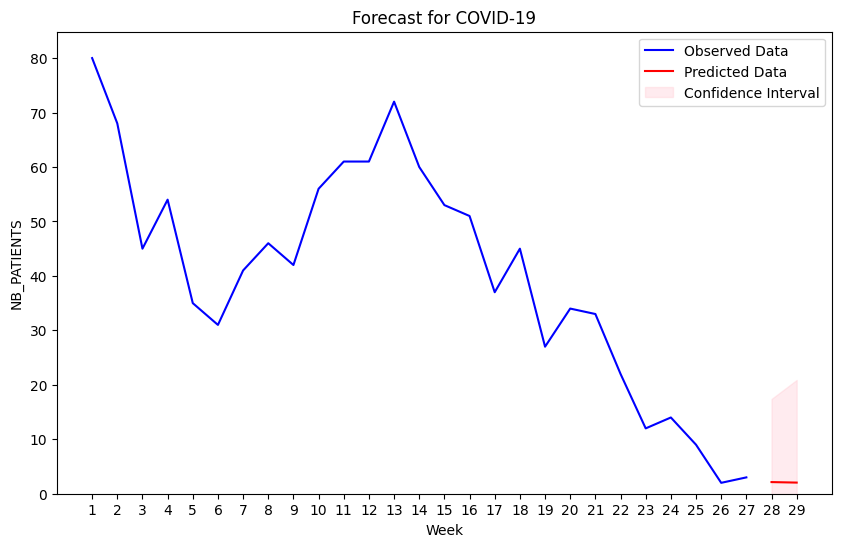

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=668733;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=210582;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=707943;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=708539;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=438747;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=531581;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

[08/25/23 16:58:49] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=108626;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=274865;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

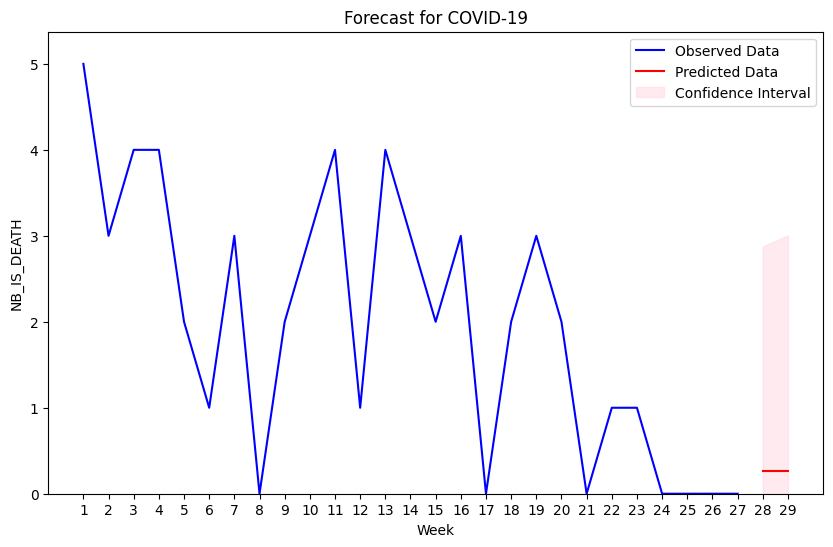

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=637105;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=268296;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=46686;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=237283;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=94874;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=27419;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=220249;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=511813;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

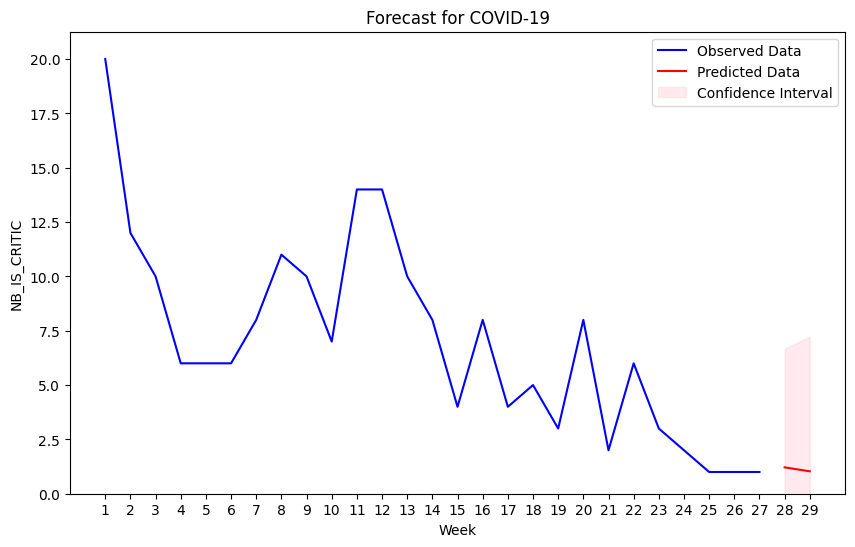

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=491561;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=662202;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=569030;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=982171;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=492191;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=822833;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=663036;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=730283;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

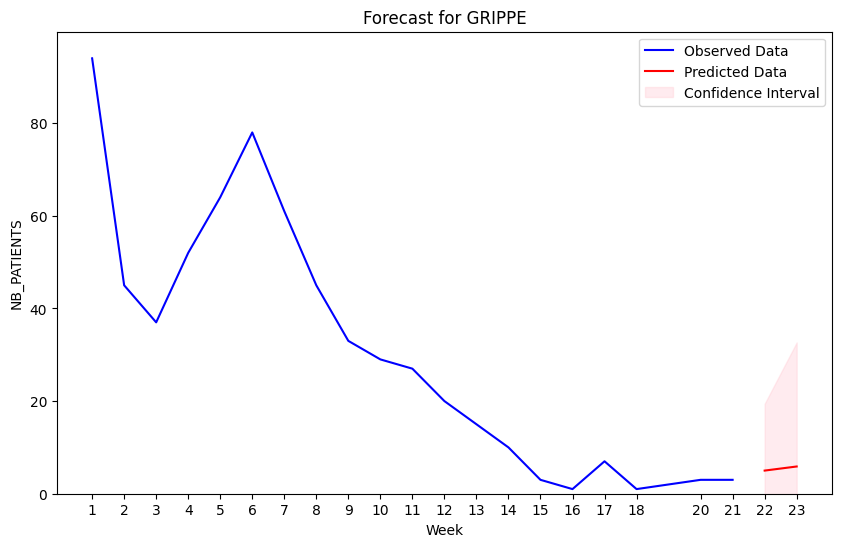

[08/25/23 16:58:50] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=934431;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=734625;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=400735;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=364468;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=109695;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=465102;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=776211;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=195545;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

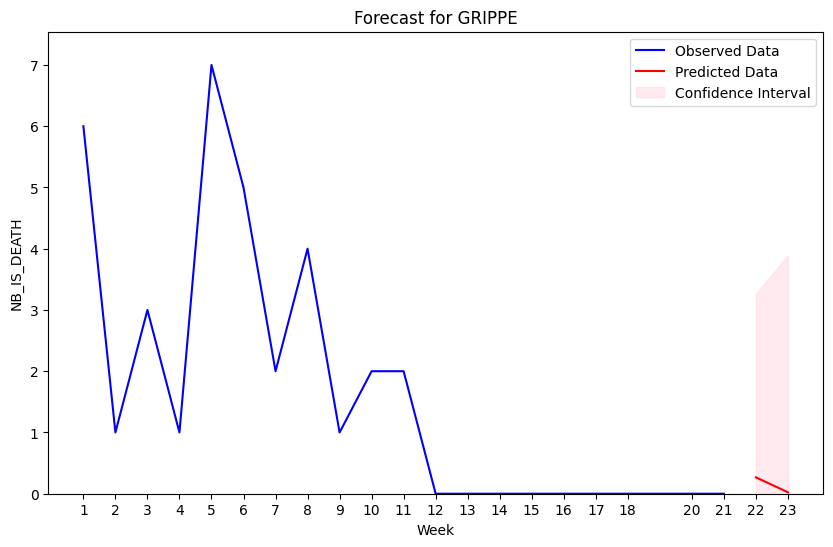

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=875041;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=731300;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=302028;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=720140;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=588350;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=84017;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=205692;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=931447;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

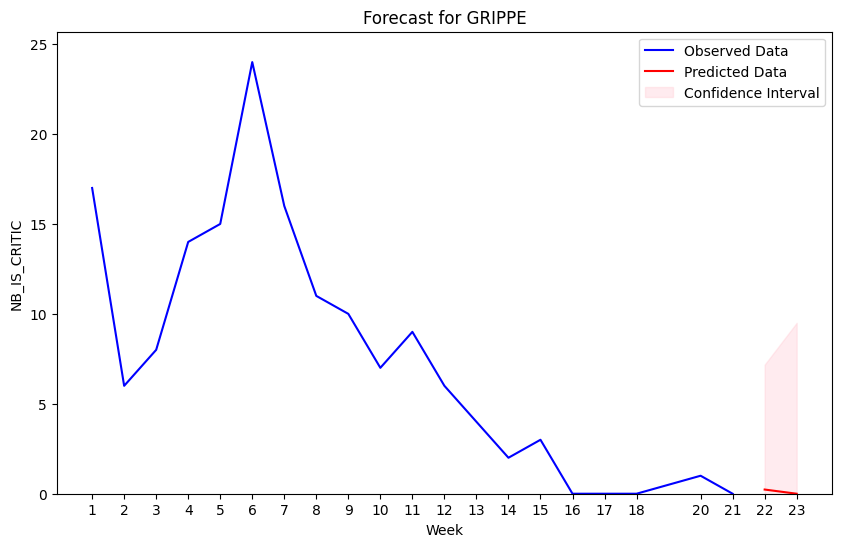

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=70718;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=590434;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=39315;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=644748;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=874701;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=777535;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=753330;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=411574;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

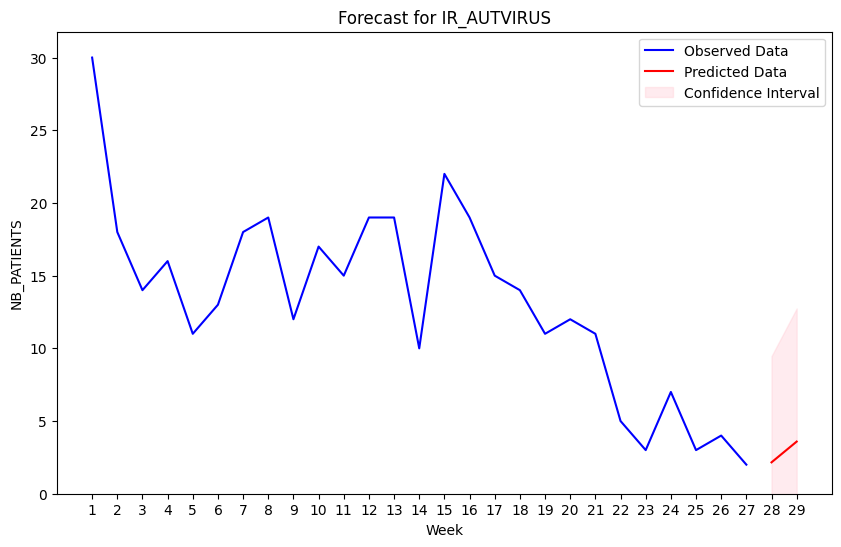

[08/25/23 16:58:51] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=863313;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=158835;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=935902;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=85634;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=626379;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=686889;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=521219;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=182427;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

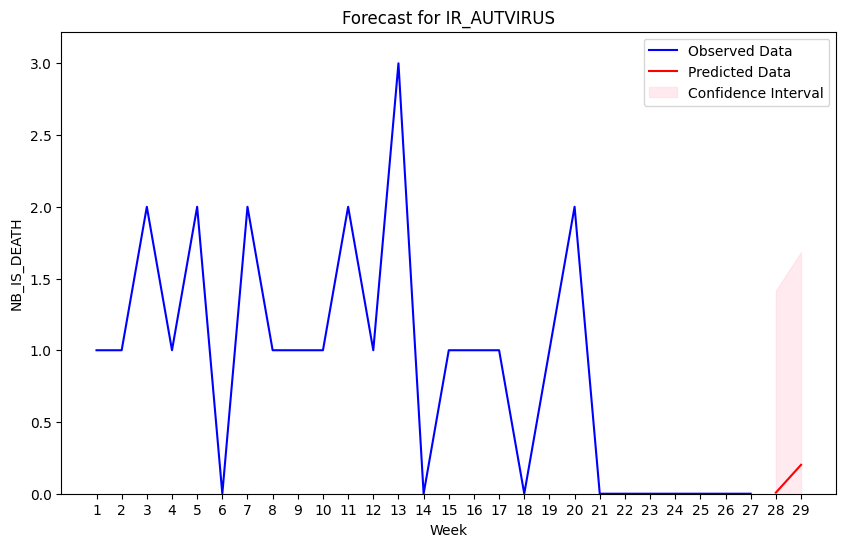

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=676963;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=632818;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=349497;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=743109;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=18436;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=931085;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=98267;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=593195;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

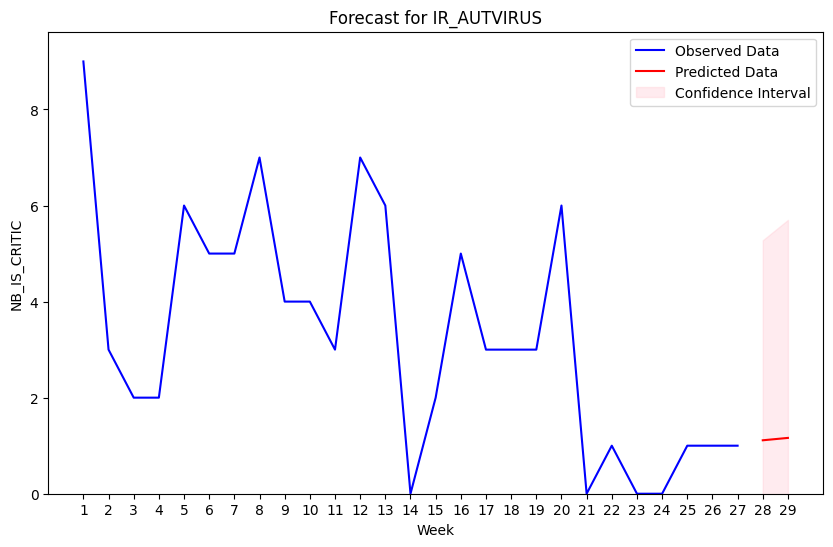

[08/25/23 16:58:52] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=863703;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=153929;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=368046;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=235087;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=409090;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=624559;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=929905;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=361879;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

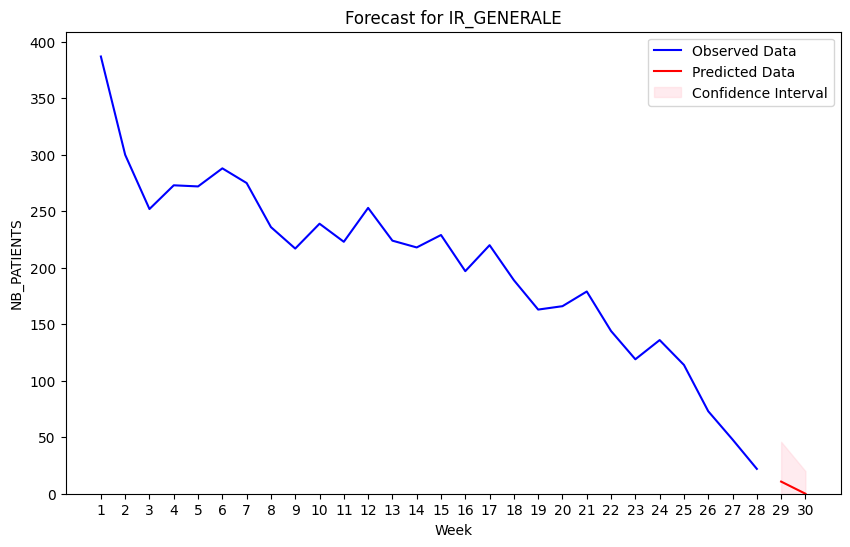

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=608621;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=189279;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=851676;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=210433;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=731558;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=670968;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=911893;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=502717;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

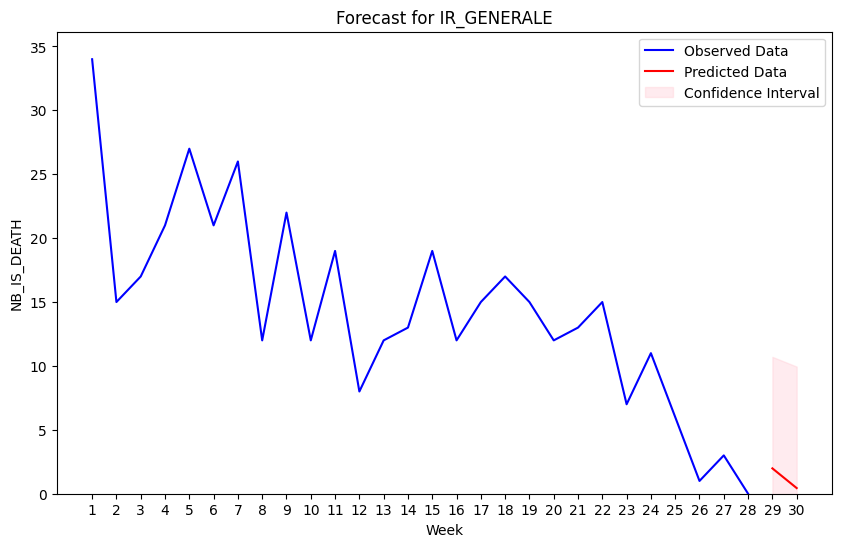

[08/25/23 16:58:53] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=36963;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=18287;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=835349;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=319992;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=981921;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=263710;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=946999;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=133393;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

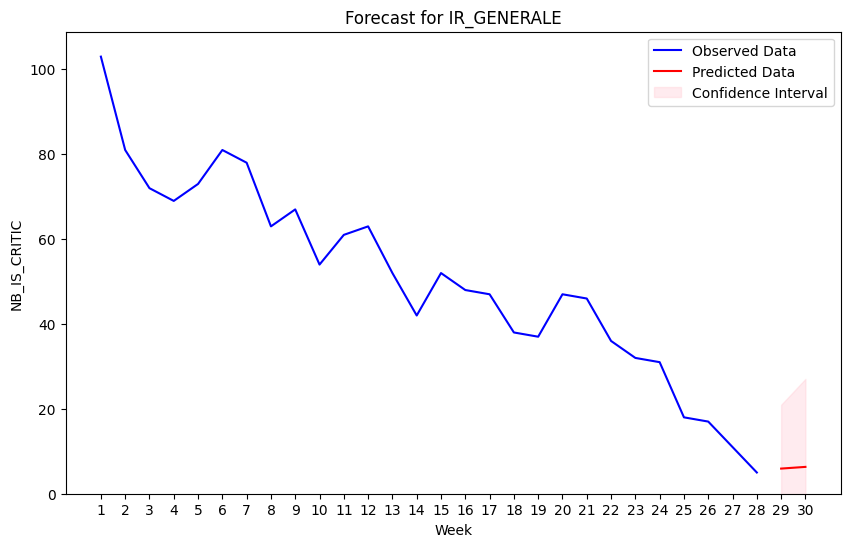

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=236253;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=727332;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=836480;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=761145;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=634323;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=267581;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=223060;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=966515;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

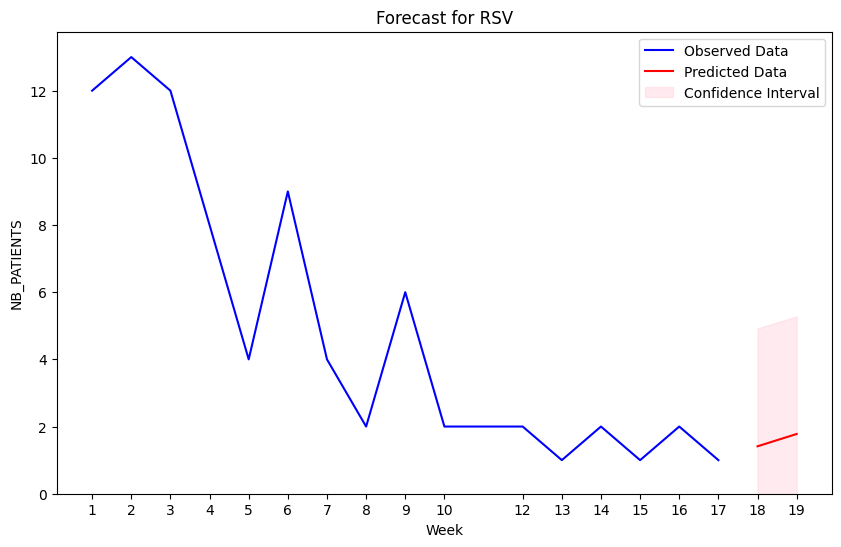

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=640126;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=576182;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=867674;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=483073;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

[08/25/23 16:58:54] WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=519765;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=112610;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=402333;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=703550;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

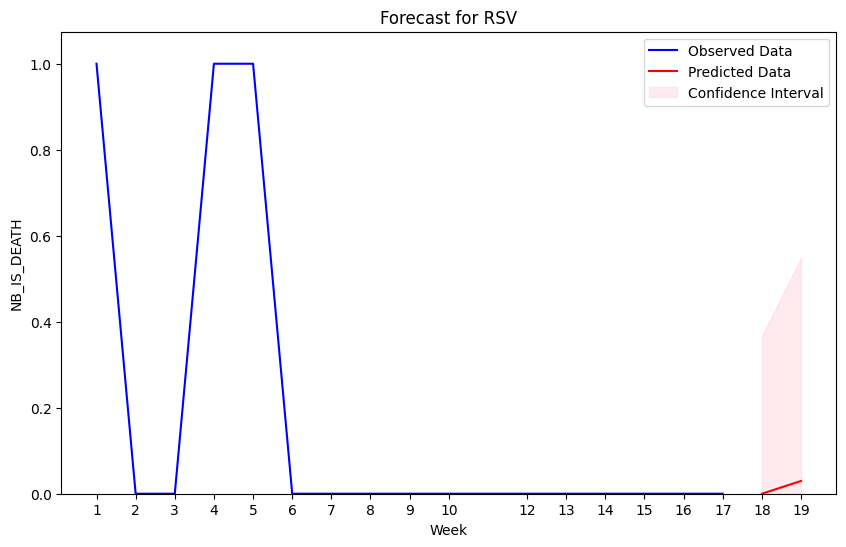

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=852311;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=974589;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=753522;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=645211;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index                 
                             was provided and will be ignored when e.g. forecasting.                               
                               self._init_dates(dates, freq)                                                       
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=902148;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=618607;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is                
                             available. Prediction results will be given with an integer index                     
                             beginning at `start`.                                                                 
                               return get_prediction_index(                                                        
                                                                                                                   

                    WARNING  c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\stat ]8;id=882368;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=671395;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             smodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index                  
                             is available. In the next version, calling this method in a model                     
                             without a supported index will result in an exception.                                
                               return get_prediction_index(                                                        
                                                                                                                   

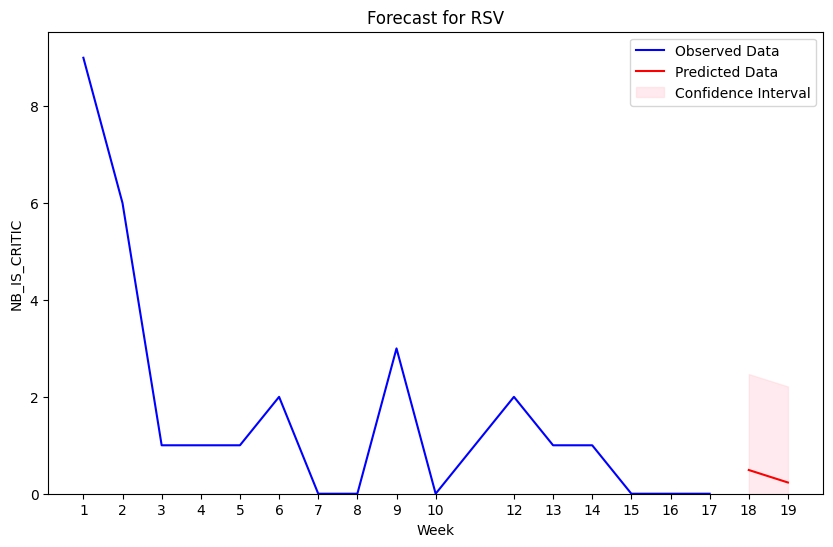

In [56]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import os
import numpy as np

# Set up the required directories
output_dir = r"C:\Users\jrubio\hcl-model-project\data\08_reporting"  # Change this to your desired directory


if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get unique flow values from the DataFrame column 'CATEG_DIAG'
flow = [i for i in df['CATEG_DIAG'].unique()]

# Dictionary to store the models
models = {}

# Iterate over each flow value
for f in flow:
    # Filter the data based on the current flow value
    data = df[df['CATEG_DIAG'] == f]
    forecasts = {}

    # Iterate over each column in the dataset
    for y_col in columns:
        
        # Create a SARIMA model instance with the best parameters
        sarima_model = SARIMAX(
            data[y_col],
            order=best_param.loc[(best_param['cat_diag'] == f) & (best_param['param'] == y_col)]['pdq'].iloc[0],
            seasonal_order=best_param.loc[(best_param['cat_diag'] == f) & (best_param['param'] == y_col)]['pdqs'].iloc[0],
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        # Fit the SARIMA model with the best parameters
        sarima_fit = sarima_model.fit(disp=False)

        # Forecast for the next weeks
        forecast_steps = 2
        forecast = sarima_fit.get_forecast(steps=forecast_steps)
        conf_int = forecast.conf_int()
        forecast.predicted_mean.values[forecast.predicted_mean.values < 0] = 0

        # Generate the index for observed and forecasted data
        time_series = data.groupby('NUM_SEMAINE')[y_col].sum()
        forecast_index = np.arange(time_series.index[-1] + 1, time_series.index[-1] + forecast_steps + 1)
        observed_index = np.concatenate((time_series.index, forecast_index))

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(observed_index, np.concatenate((time_series.values, np.full(forecast_steps, np.nan))),
                 label='Observed Data', color='blue')
        plt.plot(forecast_index, forecast.predicted_mean.values, label='Predicted Data', color='red')
        plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
        plt.title(f"Forecast for {f}")
        plt.xlabel("Week")
        plt.ylabel(f"{y_col}")
        plt.legend()
        plt.ylim(bottom=0)
        plt.xticks(observed_index)
        plt.show()

In [163]:
# Remplacer les valeurs négatives dans les colonnes spécifiées par zéro
columns_to_replace = ['NB_PATIENTS', 'NB_IS_DEATH', 'NB_IS_CRITIC']
prediction[columns_to_replace] = prediction[columns_to_replace].applymap(lambda x: max(x, 0))
prediction


NB_PATIENTS  NB_IS_DEATH  NB_IS_CRITIC     cat_diag
27     2.137628     0.261783      1.213118     COVID-19
28     2.043372     0.261783      1.030574     COVID-19
20     4.995635     0.267444      0.232635       GRIPPE
21     5.878768     0.023744      0.000000       GRIPPE
27     2.158242     0.007908      1.112645  IR_AUTVIRUS
28     3.586392     0.201439      1.162112  IR_AUTVIRUS
28    10.736941     1.984102      5.923796  IR_GENERALE
29     0.000000     0.442235      6.322831  IR_GENERALE
16     1.411904     0.000000      0.489584          RSV
17     1.778910     0.029645      0.231850          RSV